# XGBoosted Decision Tree Regression

## Importing the libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xgboost as xgb

plt.rcParams['figure.figsize'] = (7, 7)

In [ ]:
# Mounting gDrive to access dataset
from google.colab import drive
drive.mount('/content/drive')

## Importing the dataset

In [35]:
# dataset = pd.read_csv('/content/drive/My Drive/DS-Solar/DS_G33_Solar.csv')
dataset = xr.open_mfdataset('/content/drive/My Drive/DS-Solar/test/*.nc', parallel=True)
df = dataset.to_dataframe().reset_index()

In [36]:
# df = dataset.to_dataframe()
# df = dataset
d = df.loc[(df['ens'] == 0) & (df['lat'] == 31) & (df['lon'] == 254)  ] # selecting 1 ensemble and 1 location
# d['DateTime'] = d['intValidTime'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d%H')) # adding formated date time
d['DateTime'] = pd.to_datetime(d['intValidTime'], format='%Y%m%d%H')
d = d[['DateTime'] + [x for x in d if x not in ['DateTime']]] # moving DateTime col to beginning
d = d.drop(['ens', 'fhour', 'lat', 'lon', 'time', 'intTime', 'intValidTime'], axis = 1) # removing all metadata cols after selection
d = d.sort_values('DateTime') # sorting by Date Time
d = d.reset_index().drop(['index'], axis = 1) # removing old index
d['Net_Downward_Rad_Flux'] = np.sum(d[['Downward_Short-Wave_Rad_Flux', 'Downward_Long-Wave_Rad_Flux']], 
                            axis=1) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [37]:
X = d.iloc[:, 3:-1].values
y = d.iloc[:, 16].values

In [38]:
y = y.reshape(len(y),1) # transverse

## Splitting the dataset into the Training set and Test set

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Training the Random Forest Regression model on the whole dataset

In [40]:
# Instantiatethe XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=123, n_estimators=60)
# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)
# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)
# # compute the rmse: rmse
# rmse = np.sqrt(mean_squared_error(y_test, preds))
# print("RMSE: %f" % (rmse))

## Predicting the Test set results

In [41]:
# y_pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X_test)).reshape(-1,1))
np.set_printoptions(precision=2)
print(np.concatenate((preds.reshape(len(preds),1), y_test.reshape(len(y_test),1)),1))

[[ 551.33  551.66]
 [ 469.81  429.61]
 [ 883.9   862.  ]
 ...
 [ 325.04  337.  ]
 [1102.97 1123.  ]
 [ 255.24  246.76]]


## Evaluating the Model Performance

In [42]:
# compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 21.389370


In [43]:
from sklearn.metrics import r2_score
r2_score(y_test, preds)

0.9966583486518664

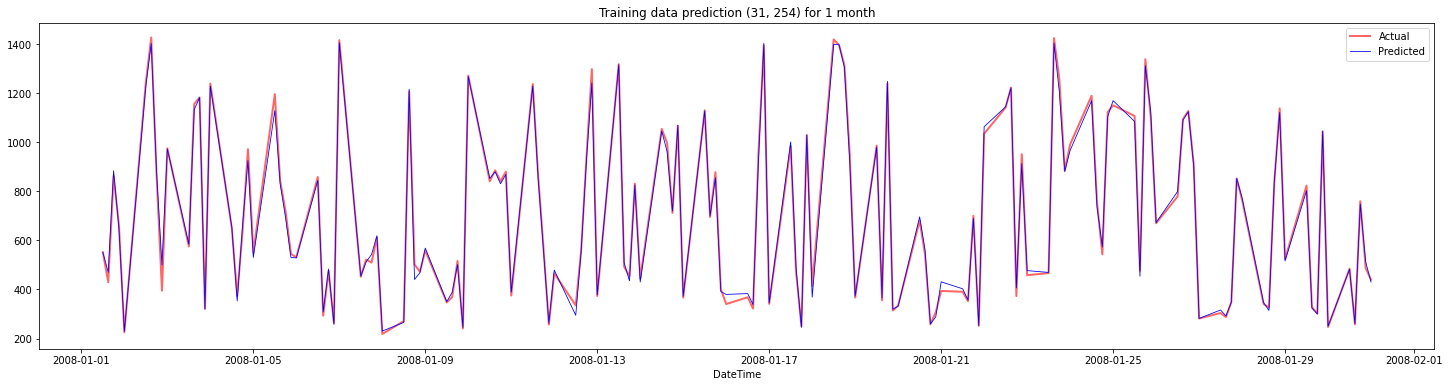

In [44]:
DateTime = d['DateTime'].iloc[:150]
y_test = y_test[:150]
preds = preds[:150]
# DateTime.shape
plt.figure(figsize=(25,6))
plt.plot(DateTime, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(DateTime, preds, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DateTime')
plt.title("Training data prediction (31, 254) for 1 month")
plt.show()

In [49]:
preds.shape

(150,)

In [54]:
# Hypo testing : z-test (n > 30)

print("\nNull hypothesis : the mean of the training data is equal to the mean of a \
sample of 150 readings of solar rad fluxes from the predicted data")

from statsmodels.stats.weightstats import ztest as ztest

# z_value,p_value=ztest(filter1['Downward_Long-Wave_Rad_Flux'], value=3.167872e+02)
# z_value , p_value = ztest(filter1['Downward_Long-Wave_Rad_Flux'], value= df['Downward_Long-Wave_Rad_Flux'].mean())
z_value , p_value = ztest(preds, value= y_test.mean())

print('\nTest statistic is %f'%float("{:.6f}".format(z_value)))

print('p-value for two tailed test is %f'%p_value)
if p_value < 0.05:    # alpha value is 0.05 or 5%
    print("\nWe are rejecting null hypothesis")
else:
    print("\nWe are accepting null hypothesis")


Null hypothesis : the mean of the training data is equal to the mean of a sample of 150 readings of solar rad fluxes from the predicted data

Test statistic is -0.082096
p-value for two tailed test is 0.934570

We are accepting null hypothesis
